In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편합니다.
plt.style.use('seaborn')
sns.set(font_scale = 2.5)

In [3]:
# pip install plotly

In [4]:
import plotly.offline as py
py.init_notebook_mode(connected = True)

In [5]:
import plotly.graph_objs as go
import plotly.tools as tls

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
%matplotlib inline

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [9]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1  # 자신 포함해야해서 1 더함
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1  # 자신 포함해야해서 1 더함

In [10]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1


In [11]:
test.loc[test.Fare.isnull(),'Fare'] = test['Fare'].mean()

In [12]:
train['Fare'] = train['Fare'].map(lambda i : np.log(i) if i > 0 else 0)
test['Fare'] = test['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

# 3. Feature engineering

In [13]:
# null data 를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지 될 수 있기 때문에, 신경써줘야할 부분입니다.
# Feature engineering 은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만 아니라 test 도 똑같이 적용해주어야 합니다.

## 3.1 Fill Null

### 3.1.1 Fill Null in Age using title

In [14]:
# Miss, Mrr, Mrs 같은 title 추출
train['Initial'] = train['Name'].str.extract('([A-Za-z]+)\.')
test['Initial'] = test['Name'].str.extract('([A-Za-z]+)\.')

In [15]:
# Initial 과 Sex 간의 count 를 살펴봅시다.
pd.crosstab(train['Initial'], train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [16]:
train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                         ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [17]:
train.groupby('Initial').mean()
# => Master / Miss / Mrs 가 생존률이 높음

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


In [18]:
train.groupby('Initial')['Survived'].mean()

Initial
Master    0.575000
Miss      0.704301
Mr        0.162571
Mrs       0.795276
Other     0.111111
Name: Survived, dtype: float64

<AxesSubplot:xlabel='Initial'>

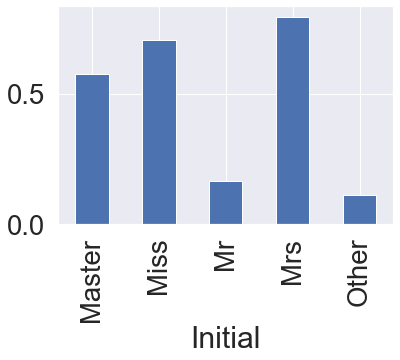

In [19]:
train.groupby('Initial')['Survived'].mean().plot.bar()

In [20]:
# # Null 값 채우는 방법 : 
# (1) statistics 를 활용하는 방법
# (2) null data 가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식

In [21]:
# 여기서 statistics 는 train data에서 얻은 값을 의미합니다.
# 언제나 test는 unseen으로 둔 상태로 놔둬야 하며, train에서 얻은 statistics를 기반으로 test의 null data를 채워줘야 합니다.

In [22]:
train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


In [23]:
# 대충 null값 채우기
train.loc[(train.Age.isnull())&(train.Initial=='Mr'),'Age'] = 33
train.loc[(train.Age.isnull())&(train.Initial=='Mrs'),'Age'] = 36
train.loc[(train.Age.isnull())&(train.Initial=='Master'),'Age'] = 5
train.loc[(train.Age.isnull())&(train.Initial=='Miss'),'Age'] = 22
train.loc[(train.Age.isnull())&(train.Initial=='Other'),'Age'] = 46

test.loc[(test.Age.isnull())&(test.Initial=='Mr'),'Age'] = 33
test.loc[(test.Age.isnull())&(test.Initial=='Mrs'),'Age'] = 36
test.loc[(test.Age.isnull())&(test.Initial=='Master'),'Age'] = 5
test.loc[(test.Age.isnull())&(test.Initial=='Miss'),'Age'] = 22
test.loc[(test.Age.isnull())&(test.Initial=='Other'),'Age'] = 46

### 3.1.2 Fill Null in Embarked

In [24]:
print('Embarked has',sum(train['Embarked'].isnull()), 'Null values')

Embarked has 2 Null values


In [25]:
# Embarked 는 Null value 가 2개이고, S 에서 가장 많은 탑승객이 있었으므로, 간단하게 Null 을 S로 채우겠습니다.
train['Embarked'].fillna('S', inplace=True)

## 3.2 Change Age(continuous to categorical)

In [26]:
# Age는 현재 continuous feature 입니다. 이대로 써도 모델을 세울 수 있지만, Age를 몇개의 group으로 나누어 category화 시켜줄 수도 있습니다. continuous를 categorical로 바꾸면 자칫 information loss가 생길 수도 있습니다만, 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.

In [27]:
## 귀찮은 방법
# 10살 간격으로 나눔
train['Age_cat'] = 0
train.loc[train['Age'] < 10, 'Age_cat'] = 0
train.loc[(10 <= train['Age']) & (train['Age'] < 20), 'Age_cat'] = 1
train.loc[(20 <= train['Age']) & (train['Age'] < 30), 'Age_cat'] = 2
train.loc[(30 <= train['Age']) & (train['Age'] < 40), 'Age_cat'] = 3
train.loc[(40 <= train['Age']) & (train['Age'] < 50), 'Age_cat'] = 4
train.loc[(50 <= train['Age']) & (train['Age'] < 60), 'Age_cat'] = 5
train.loc[(60 <= train['Age']) & (train['Age'] < 70), 'Age_cat'] = 6
train.loc[70 <= train['Age'], 'Age_cat'] = 7

test['Age_cat'] = 0
test.loc[test['Age'] < 10, 'Age_cat'] = 0
test.loc[(10 <= test['Age']) & (test['Age'] < 20), 'Age_cat'] = 1
test.loc[(20 <= test['Age']) & (test['Age'] < 30), 'Age_cat'] = 2
test.loc[(30 <= test['Age']) & (test['Age'] < 40), 'Age_cat'] = 3
test.loc[(40 <= test['Age']) & (test['Age'] < 50), 'Age_cat'] = 4
test.loc[(50 <= test['Age']) & (test['Age'] < 60), 'Age_cat'] = 5
test.loc[(60 <= test['Age']) & (test['Age'] < 70), 'Age_cat'] = 6
test.loc[70 <= test['Age'], 'Age_cat'] = 7

In [28]:
# 함수 만들어서 apply 메소드에 넣어줌
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7    
    
train['Age_cat_2'] = train['Age'].apply(category_age)

In [29]:
# 두가지 방법이 잘 적용됬다면, 둘다 같은 결과를 내야합니다.
# 이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용합시다. all() 메소드는 모든 값이 True 면 True, 하나라도 False 가 있으면 False 를 줍니다.

In [30]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 -> ', (train['Age_cat'] == train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함 ->  True


In [31]:
# => 둘 중 편한 걸 선택하시면 됩니다.
#    중복되는 Age_cat 컬럼과 원래 컬럼 Age 를 제거

In [32]:
train.drop(['Age','Age_cat_2'], axis = 1, inplace=True)
test.drop(['Age'], axis = 1, inplace=True)

## 3.3 Change Initial, Embarked and Sex (string to numerical)

In [33]:
# 현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.
# map method 를 가지고 간단히 할 수 있습니다.
# 사전 순서대로 정리하여 mapping 하겠습니다

In [34]:
train['Initial'] = train['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})
test['Initial'] = test['Initial'].map({'Master':0, 'Miss':1, 'Mr':2, 'Mrs':3, 'Other':4})

In [35]:
# Embarked 도 C, Q, S로 이루어져 있습니다. map 을 이용해 바꿔봅시다.
# 그러기 앞서서, 특정 column 에 어떤 값들이 있는 지 확인해보는 방법을 잠깐 살펴보겠습니다. 간단히 unique() 메소드를 쓰거나, value_counts() 를 써서 count 까지 보는 방법이 있습니다.

In [36]:
train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [37]:
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [38]:
train['Embarked'] = train['Embarked'].map({'C':0,'Q':1,'S':2})
test['Embarked'] = test['Embarked'].map({'C':0,'Q':1,'S':2})

In [39]:
train['Embarked'].isnull().any()

False

In [40]:
# any() 를 사용하여, True 가 단하나라도 있을 시(Null이 한개라도 있을 시) True 를 반환해주게 됩니다. 우리는 Null 을 S로 다 바꿔주었으므로 False 를 얻게 됩니다

In [41]:
train['Sex'] = train['Sex'].map({'female':0,'male':1})
test['Sex'] = test['Sex'].map({'female':0,'male':1})

In [42]:
# 이제 각 feature 간의 상관관계를 한번 보려고 합니다.
# 우리는 여러 feature 를 가지고 있으니 이를 하나의 maxtrix 형태로 보면 편할 텐데, 이를 heatmap plot 이라고 하며, dataframe 의 corr() 메소드와 seaborn 을 가지고 편하게 그릴 수 있습니다.

In [43]:
heatmap_data = train[['Survived','Pclass','Sex','Fare','Embarked','FamilySize','Initial','Age_cat']]
heatmap_data.head(3)

,Survived,Pclass,Sex,Fare,Embarked,FamilySize,Initial,Age_cat
0,0,3,1,1.981001,2,2,2,2
1,1,1,0,4.266662,0,2,3,3
2,1,3,0,2.070022,2,1,1,2


In [44]:
colormap = plt.cm.RdBu
colormap

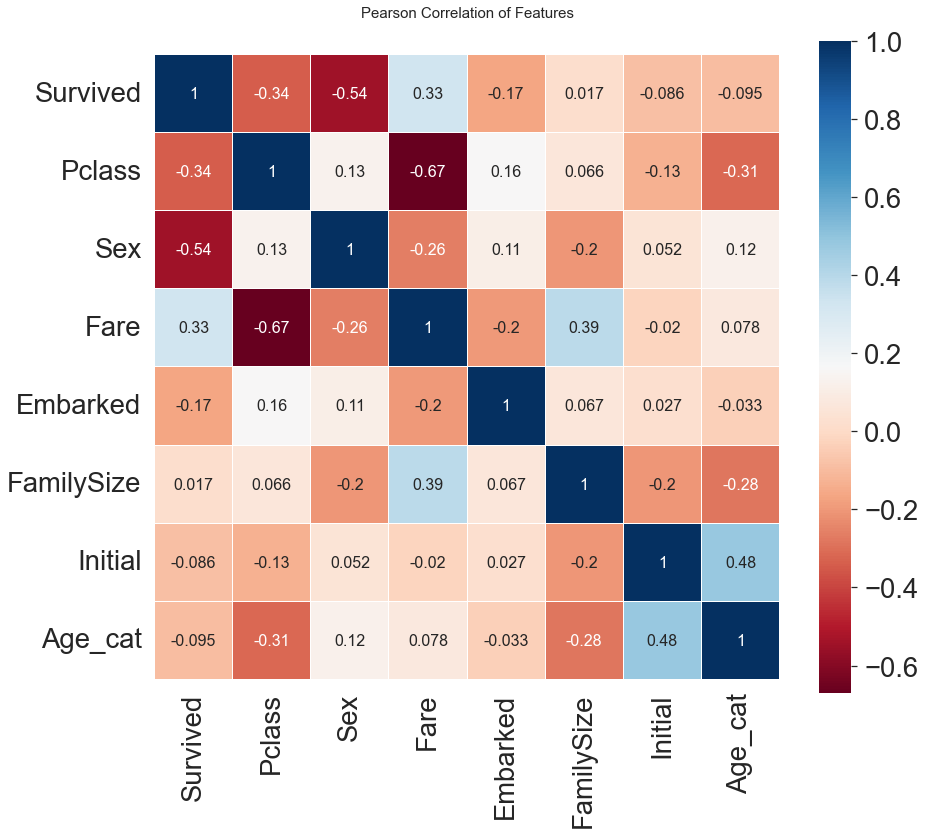

In [45]:
plt.figure(figsize = (14,12))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)

# annot=True : 상관계수 값 표시
# annot_kws={'size':16} : 상관계수 값 글자 크기 키우기
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = 'white', annot=True, annot_kws={'size':16})
del heatmap_data

In [46]:
# 우리가 EDA에서 살펴봤듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음을 볼 수 있습니다.
# 생각보다 fare 와 Embarked 도 상관관계가 있음을 볼 수 있습니다.
# 또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것입니다.
# 이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature 가 없다는 것을 의미합니다. 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.
# 이제 실제로 모델을 학습시키기 앞서서 data preprocessing (전처리)을 진행해보겠습니다.

## 3.4 One-hot encoding on Initial and Embarked

In [47]:
# 수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.
# 수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것을 말합니다.
# One-hot encoding 은 위 카테고리를 아래와 같이 (0, 1) 로 이루어진 5차원의 벡터로 나타내는 것을 말합니다.
# 직접 코딩할 수도 있지만, pandas 의 get_dummies 를 사용하여 쉽게 해결 할 수 있습니다.
# 총 5개의 카테고리니, one-hot encoding 을 하고 나면 새로운 5개의 column 이 생겨납니다.
# Initial 을 prefix로 두어서 구분이 쉽게 만들어 줍니다.

In [48]:
train = pd.get_dummies(train, columns = ['Initial'], prefix = 'Initial')  # columns : 특정 컬럼만 지정해서 one-hot encoding 할 수 있음
test = pd.get_dummies(test, columns = ['Initial'], prefix = 'Initial')  # dtype = float : one-hot 값을 float 형식으로 뱉어줌

In [49]:
test.head(3)

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,892,3,"Kelly, Mr. James",1,0,0,330911,2.057860,NaN,1,1,3,0,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,1,0,363272,1.945910,NaN,2,2,4,0,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",1,0,0,240276,2.270836,NaN,1,1,6,0,0,1,0,0


In [50]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0


In [51]:
train = pd.get_dummies(train, columns = ['Embarked'], prefix = 'Embarked')
test = pd.get_dummies(test, columns = ['Embarked'], prefix = 'Embarked')

In [52]:
# sklearn 로 Labelencoder + OneHotencoder 이용해도 one-hot encoding 이 가능합니다.
# 여기서는 get_dummies 로 충분히 가능하기 때문에 get_dummies 만으로 끝내겠습니다.
# 가끔 category 가 100개가 넘어가는 경우가 있습니다. 이때 one-hot encoding을 사용하면 column이 100개가 생겨, 학습시 매우 버거울 경우가 있습니다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보겠습니다.

## 3.5 Drop columns

In [53]:
# 필요한 컬럼 외 제거

In [54]:
train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis = 1, inplace = True)
test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [55]:
train.head(3)

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1


In [56]:
test.head(3)

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0


In [57]:
# train 의 Survived feature(target class)를 빼면 train, test 둘다 같은 columns 를 가진 걸 확인할 수 있습니다.

# 4 Building machine learning model and prediction using the trained model

In [58]:
from sklearn.ensemble import RandomForestClassifier  # 모델
from sklearn import metrics  # 모델 평가
from sklearn.model_selection import train_test_split  # training set을 나눠주는 함수

## 4.1 Preparation - Split dataset into train, valid, test set

In [62]:
x_train = train.drop('Survived', axis = 1).values
target_label = train['Survived'].values
x_test = test.values

In [65]:
x_tr, x_vld, y_tr, y_vld = train_test_split(x_train, target_label, test_size = 0.3, random_state = 2022)

## 4.2 Model generation and prediction

In [74]:
model = RandomForestClassifier()
model.fit(x_tr, y_tr)
prediction = model.predict(x_vld)

In [75]:
prediction

array([0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [77]:
# 랜덤포레스트는 모델 학습(순간)에 따라 정확도가 계속 변함
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 79.85% 정확도로 생존을 맞춤


## 4.3 Feature importance

In [80]:
from pandas import Series
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index = test.columns)

In [81]:
feature_importance

array([0.09736627, 0.11697837, 0.31127267, 0.10289015, 0.11123794,
       0.01418672, 0.04210388, 0.12401584, 0.03494573, 0.00607129,
       0.01175115, 0.01108909, 0.0160909 ])

In [82]:
Series_feat_imp

Pclass        0.097366
Sex           0.116978
Fare          0.311273
FamilySize    0.102890
Age_cat       0.111238
Initial_0     0.014187
Initial_1     0.042104
Initial_2     0.124016
Initial_3     0.034946
Initial_4     0.006071
Embarked_0    0.011751
Embarked_1    0.011089
Embarked_2    0.016091
dtype: float64

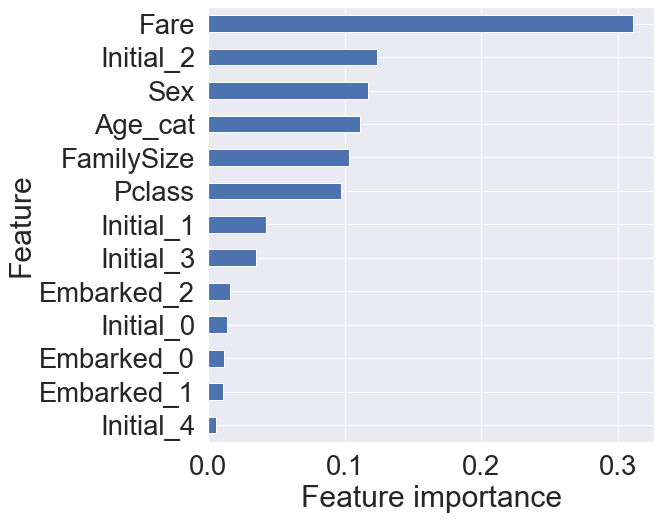

In [85]:
plt.figure(figsize = (8,8))
Series_feat_imp.sort_values(ascending = True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
# feature importance 는 지금 모델에서의 importance 를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance 가 다르게 나올 수 있습니다.
# 이 feature importance 를 보고 실제로 Fare 가 중요한 feature 일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야합니다.
# featuure importance 를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection 을 할 수도 있고, 좀 더 빠른 모델을 위해 feature 제거를 할 수 있습니다.

## 4.4 Prediction on Test set

In [ ]:
# 이제 모델이 학습하지 않았던(보지 않았던) 테스트셋을 모델에 주어서, 생존여부를 예측해보겠습니다.
# 이 결과는 실제로 submission(제출용) 이므로 결과는 leaderboard 에서 확인할 수 있습니다.
# 캐글에서 준 파일, gender_submission.csv 파일을 읽어서 제출 준비를 하겠습니다.

In [87]:
submission = pd.read_csv('gender_submission.csv')
submission

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [ ]:
# 이제 testset 에 대하여 예측을 하고, 결과를 csv 파일로 저장해보겠습니다.

In [89]:
prediction = model.predict(x_test)
submission['Survived'] = prediction

In [91]:
len(x_test)

418

In [100]:
submission

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


In [101]:
test

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,1,2.085672,1,3,0,0,1,0,0,0,0,1
414,1,0,4.690430,1,3,0,0,1,0,0,1,0,0
415,3,1,1.981001,1,3,0,0,1,0,0,0,0,1
416,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [102]:
pd.DataFrame(x_test)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,3.0,1.0,2.057860,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,3.0,0.0,1.945910,2.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,2.0,1.0,2.270836,1.0,6.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,3.0,1.0,2.159003,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3.0,0.0,2.508582,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3.0,1.0,2.085672,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
414,1.0,0.0,4.690430,1.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
415,3.0,1.0,1.981001,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
416,3.0,1.0,2.085672,1.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
submission.to_csv('first_submission.csv', index = False)